# Anomaly Detection - Zelong
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

<br>

**Dennis Milechin, Ivan Sunyagin, Hany Bassily**

<br>
## Beta Version for Hurricane Matthew


<br>

Import libraries

In [12]:
import numpy as np
import pandas as pd
import scipy as sp

#import pydotplus
from IPython import display
from IPython.display import Image
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("paper")
#sns.set_palette("RdBu", n_colors=32)
#from inspect import getmembers

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors

from scipy import stats
from scipy.stats import gaussian_kde as PDF
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
#from sklearn.model_selection import cross_val_score as KFcv
#from sklearn.model_selection import KFold
#from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
#from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier as BaseLine
from sklearn.decomposition import PCA
from sklearn.utils import resample

import StringIO
import collections
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

**---**

## Open a datasets

<br>

In [13]:
# Open data sets:
# --------------

# Data dictionary
data_dic = {}

# specify date columns
date_range = [[0,1,2,3,4]]

# Open the data files
for i in range(5):
    file_name = 'datasets/data_' + str(i+1) + '.txt'
    inter = pd.read_csv(file_name , delim_whitespace = True , skiprows = [1],
                                              parse_dates = date_range , infer_datetime_format = True)
    data_dic['df_' + str(i + 1)] = inter.iloc[:,1:]

# Sanity check    
data_dic['df_1'].head(10)

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,104,7.9,9.5,99.00,99.00,99.00,999,1012.8,27.9,28.4,26.0,99.0,99.0
1,103,7.6,9.8,99.00,99.00,99.00,999,1013.0,28.2,28.4,26.6,99.0,99.0
2,102,8.9,11.0,99.00,99.00,99.00,999,1013.1,28.2,28.4,26.4,99.0,99.0
3,105,8.5,10.3,99.00,99.00,99.00,999,1013.2,28.3,28.3,26.3,99.0,99.0
4,105,8.6,10.2,1.54,6.67,5.03,89,1013.4,28.2,28.3,25.9,99.0,99.0
5,104,7.7,9.6,99.00,99.00,99.00,999,1013.3,28.3,28.3,26.3,99.0,99.0
6,102,8.2,9.9,99.00,99.00,99.00,999,1013.4,28.3,28.4,26.4,99.0,99.0
7,101,8.8,10.8,99.00,99.00,99.00,999,1013.4,28.3,28.3,26.4,99.0,99.0
8,100,8.4,10.2,99.00,99.00,99.00,999,1013.8,28.3,28.3,26.5,99.0,99.0
9,101,8.4,10.2,99.00,99.00,99.00,999,1013.8,28.3,28.3,26.5,99.0,99.0


In [14]:
# Concatenate all files:
# ---------------------

# initiation
df_global_raw = data_dic['df_1']

# concatente

title = ['WSPD' , 'GST' , 'PRES' , 'ATMP']
# title = ['WDIR' , 'WSPD' , 'GST' , 'PRES' , 'ATMP' , 'DEWP']

for i in range(2,6):
    df_global_raw = pd.concat([df_global_raw , data_dic['df_' + str(i)]] , axis = 0)
    
df_global = df_global_raw[title]

# data array
data_raw = df_global.values

In [15]:
# Preprocessing
# -------------

# determine defected rows
defect = []

# itterrate
for i in range (data_raw.shape[0]):
    if data_raw[i,-1] > 200.:
        defect.append(i)

# remove rows
data = np.delete(data_raw, defect, axis = 0)

In [16]:
# simulated Data
# --------------

d1 = np.random.normal(0. , 0.5 , (3000 , 2))
d2 = np.random.normal(0. , 0.9 , (500 , 2))
d3 = np.random.normal(0. , 0.5 , (3000 , 2))

sim_data1 = np.concatenate((d1, d2) , axis = 0)
sim_data = np.concatenate((sim_data1 , d3), axis = 0)

In [17]:
# Function to calculate Power Martingale:
# ---------------------------------------

def power_martingale(data , eps , delay, sim = False):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
        
    if(sim):
        d = data
 
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i + 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.0000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.
    
    # initiate difference measure
    diff_arr = np.zeros((L,))
    
    # Initiate difference multiplier
    diff = 1.

    # iterrate for power martingale calculation
    for i in range(L):
        
        # increment
        delta = eps * (p_value[i]) ** (eps - 1.)
        
        # Calculate martingale difference
        # diff_arr[i] = np.log( np.absolute(diff * (delta - 1.)) )
        diff_arr[i] = np.absolute(np.log(delta))
        
        # Update power martingal
        M += np.log(delta)  
        
        # Array
        power_mart[i] = M
        
    return power_mart , diff_arr

In [18]:
# Kalman Filter
# ------------

def kalman(y):
    
    # initiation of the filtered signal array
    x = np.zeros(y.shape)
    
    # Filter parameters
    p = np.zeros(y.shape)
    q = 0.001
    r = 10.
    
    # Data size
    L = y.shape[0]
    
    # Start with first elements definition
    x[0] = y[0]
    p[0] = 10
    
    # Iterrate for new samples
    for i in range(1,L):
        p[i] = p[i - 1] + q
        k = p[i] / (p[i] + r)
        x[i] = x[i - 1] + k * (y[i] - x[i - 1])
        p[i] = p[i] * ( 1 - k )
        
    return x

In [19]:
# Exponential Smoother:
# ---------------------

def smooth(y , alpha):
    
    # initiation of the filtered signal array
    x = np.zeros(y.shape)
    
    # Data size
    L = y.shape[0]
    
    # intiation
    x[0] = 0.5 * (1. + alpha) * y[0]
    
    # Iterrate for new samples
    for i in range(1,L):
        x[i] = alpha * y[i] + (1. - alpha) * x[i - 1]
        
    return x

In [26]:
# Tune for e and delay:
#----------------------

# Selected epsilon array
e_array = np.linspace(0.1,0.9,50)

# selected delay array
delay_array = np.linspace(1,500,500)

# Dimensions
rows = len(delay_array)
cols = len(e_array)

# Initiation of measure array
measure = np.zeros((rows, cols))

for i in range(rows):
    
    # specify delsy
    de = int(delay_array[i])
    
    # Iterrate for each column
    for j in range(cols):
        
        # specify epsilon
        e = e_array[j]
        display.clear_output(wait=True)
        display.display([e , de , i , j])
        
        # evaluate the difference
        pmar, dif = power_martingale(data,e , de)
        
        # maximum ata Matthew
        dif_max = np.max(dif[17000:18000])
        
        # Put in measure array
        measure[i,j] = dif_max


                   

[0.90000000000000002, 500]

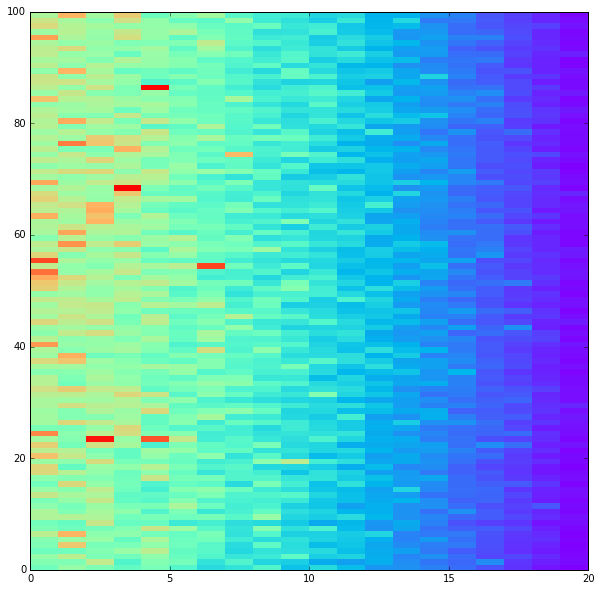

In [39]:
# Viisualize Tunning results:
# ---------------------------

fig = plt.figure(figsize = (10,10))

clr_map = plt.get_cmap('rainbow')

ax = fig.add_subplot(111)
ax.pcolor(measure , cmap = clr_map)

plt.show()

In [45]:
# Best Values
# -----------

best_de = int(delay_array[np.argmax(measure) / cols])
best_e = e_array[np.argmax(measure) - best_row * cols]

In [46]:
# Application and Visualization (Power Martingale)
# -----------------------------------------------

# simulated data 
p_mar1 , diff1 = power_martingale(sim_data,best_e , best_de , sim = True)

# Filtered data
p_mar2, diff2 = power_martingale(data,best_e , best_de)

##

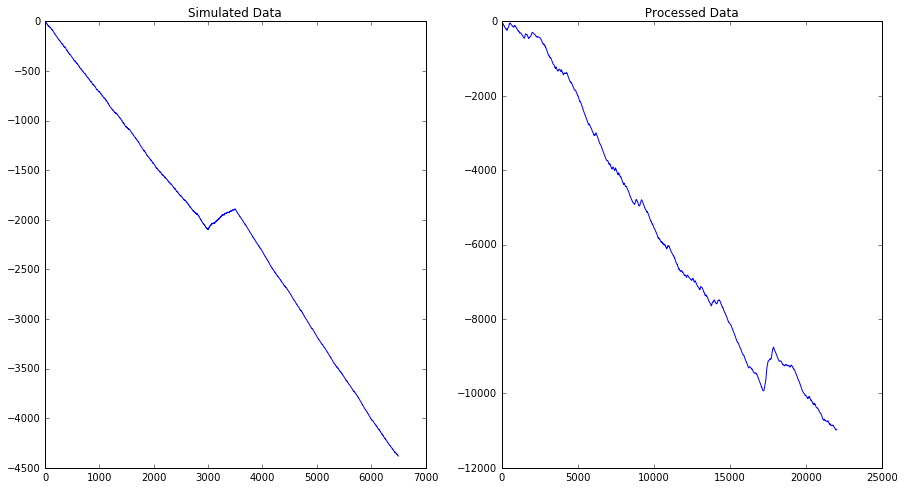

In [47]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (15,8))

# plot simulated data
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar1)
ax1.set_title('Simulated Data')

# plot raw data
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar2)
ax2.set_title(' Processed Data ')

plt.show()

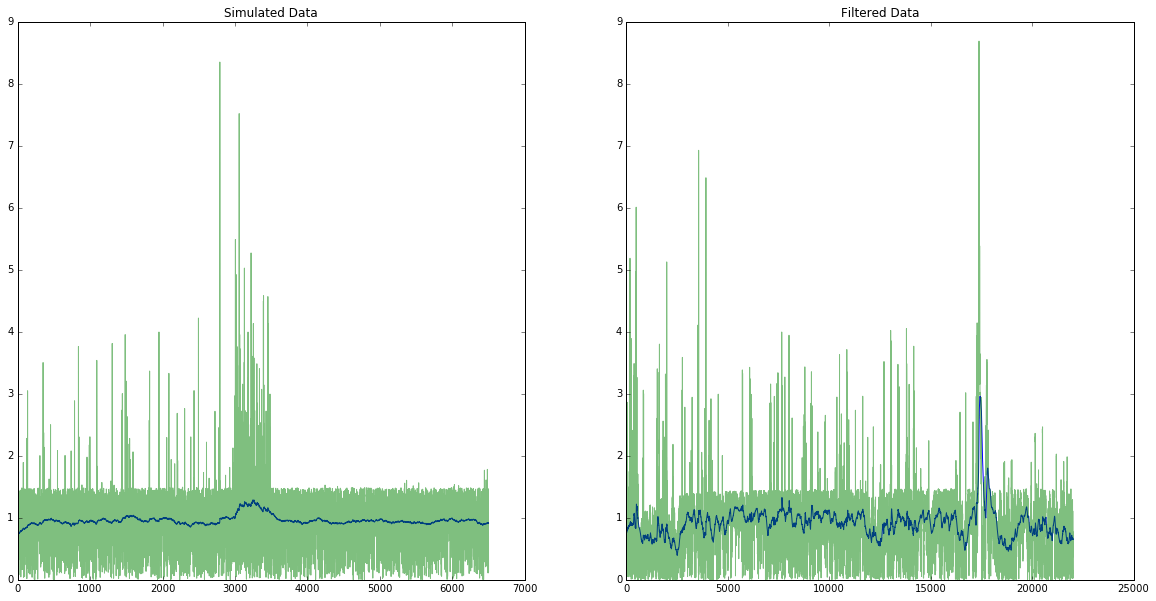

In [48]:
# Visualize change detection
# --------------------------

fig = plt.figure(figsize = (20,10))

a = 0.008

# determine length
L = diff1.shape[0]

# Simulated Data
ax1 = fig.add_subplot(121)
ax1.plot(smooth(diff1 , a))
ax1.plot(diff1 , alpha = 0.5)
ax1.set_title('Simulated Data')

# Processed data data
ax2 = fig.add_subplot(122)
ax2.plot(smooth(diff2 , a) )
ax2.plot(diff2 , alpha = 0.5)
ax2.set_title('Filtered Data')

plt.show()

In [49]:
# Function to generate a heatmap array based on Kalman filter
# -----------------------------------------------------------

def heatmap_fil(x , alpha):
    
    # signal length
    L = x.shape[0]
    
    # apply Kalman filter
    xk = smooth(x , alpha)
    
    # reshape arrays
    x1 = xk.reshape((1,L)) / np.max(xk)
    x2 = x.reshape((1,L)) / np.max(x)
    
    # Augment arrays
    big1 = np.concatenate((x1 , x1) , axis = 0)
    big2 = np.concatenate((x2 , x2) , axis = 0)
    
    # Join arrays
    big = np.concatenate((big1 , big2) , axis = 0)
    
    return big
        


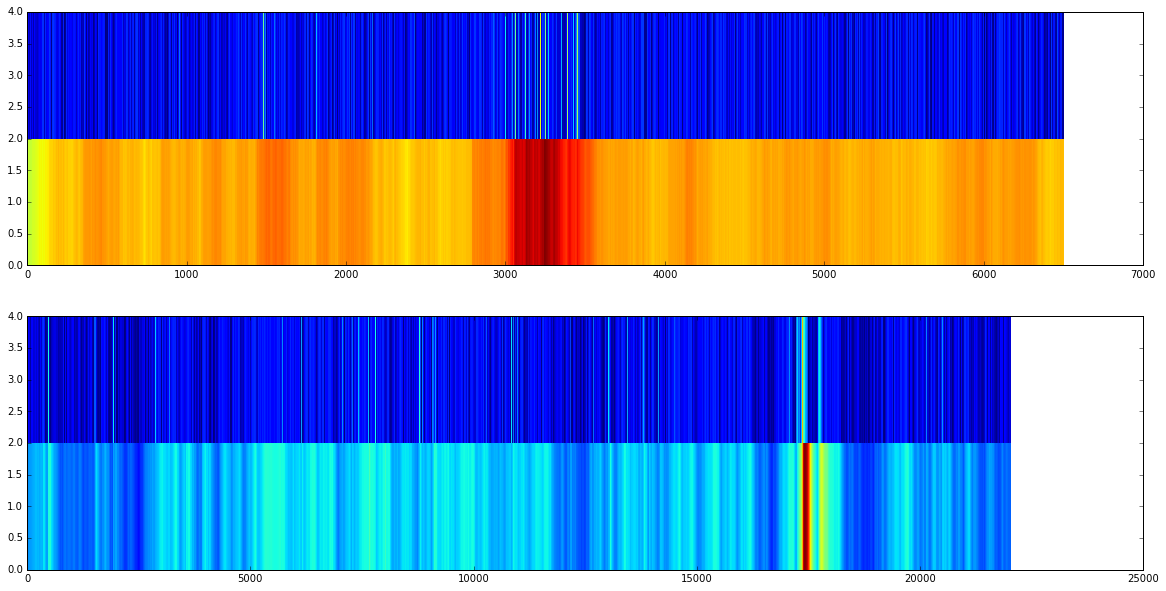

In [50]:
# visualize the heatmaps:
# -----------------------

fig = plt.figure(figsize = (20,10))

clr = plt.get_cmap('jet')

#
ht1 = heatmap_fil(diff1 , a)
ax1 = fig.add_subplot(2,1,1)
ax1.pcolor(ht1 , cmap = clr)

#
ht2 = heatmap_fil(diff2 , a)
ax2 = fig.add_subplot(2,1,2)
ax2.pcolor(ht2 , cmap = clr)

plt.show()

In [51]:
# Integral function to calculate the mixture Power Martingale:
# ------------------------------------------------------------

def trap_mix(m,e):
    
    # initiate integral
    integral = 0.
    
    # iterrate over all values of epsilon
    for i in range (len(e) - 1):
        
        # trapezoid
        b = 0.5 * (m[i] + m[i + 1])
        h = e[i + 1] - e[i]
        
        # Integral
        integral += b * h
        
    return integral
        

In [52]:
# Function to calculate Power Martingale:
# ---------------------------------------

def power_martingale_mix(data , res , delay, sim = False):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
        
    if(sim):
        d = data

    # epsilon array
    eps = np.linspace(0.001, 0.999, res)
    
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i - 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        p_value[i] = ( np.sum(alpha_sub > end) + np.random.uniform() * np.sum(alpha_sub == end ) ) / n
    
        # to avoid log zero
        p_value[p_value==0] = 0.00000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)
    
    # initiate difference
    diff_arr = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.

    # iterrate for power martingale calculation
    for i in range(L):
    
        # Calculate delta Array    
        delta = np.log(eps) + (eps - 1.) * np.log(p_value[i])
        
        # Integrate for mix
        delta_mix = trap_mix(delta , eps)
        
        # update power martingale
        M += delta_mix
        
        # Array
        power_mart[i] = M
        
        # difference
        diff_arr[i] = np.absolute(delta_mix)
        
        
    return power_mart , diff_arr

In [53]:
# Tune for delay:
#----------------

# integration resolution
resolution = 100

# selected delay array
delay_array = np.linspace(1,500,500)

# Dimensions
rows = len(delay_array)

# Initiation of measure array
measure_m = np.zeros((rows,))

for i in range(rows):
    
    # specify delsy
    de = int(delay_array[i])
    
    # display progress
    display.clear_output(wait=True)
    display.display([de , i])
        
    # evaluate the difference
    pmar, dif = power_martingale_mix(data, resolution , de)
        
    # maximum data Matthew
    dif_max = np.max(dif[17000:18000])
        
    # Put in measure array
    measure_m[i] = dif_max


                   

[500, 499]

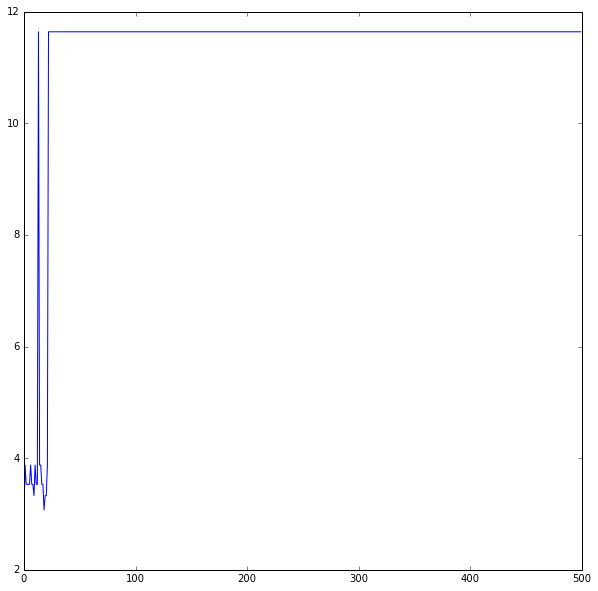

In [59]:
# Viisualize Tunning results:
# ---------------------------

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)
ax.plot(measure)

plt.show()

In [77]:
# Best Values
# -----------

best_de_m = int(delay_array[np.argmax(measure)])

In [72]:
# Application and Visualization (Power Martingale)
# -----------------------------------------------

# simulated data 
p_mar1 , diff1 = power_martingale_mix(sim_data,resolution , best_de_m , sim = True)

# Filtered data
p_mar2, diff2 = power_martingale_mix(data,resolution , best_de_m)

##

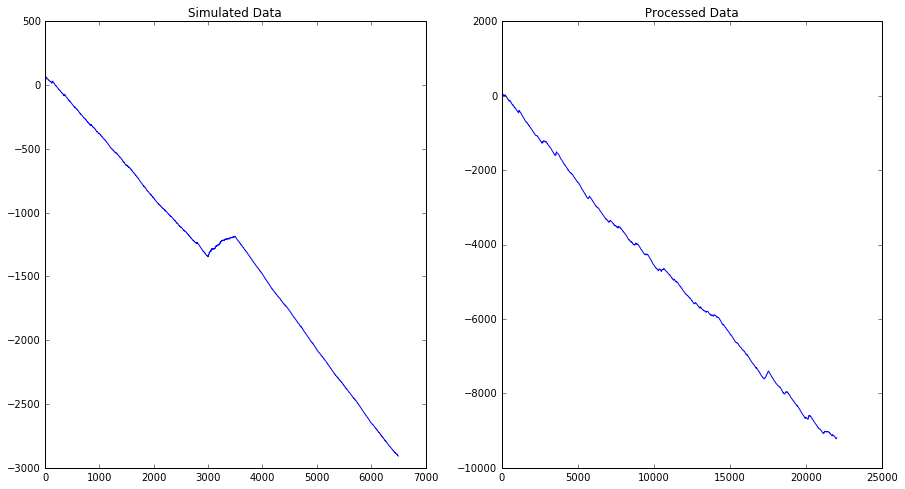

In [73]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (15,8))

# plot simulated data
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar1)
ax1.set_title('Simulated Data')

# plot raw data
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar2)
ax2.set_title(' Processed Data ')

plt.show()

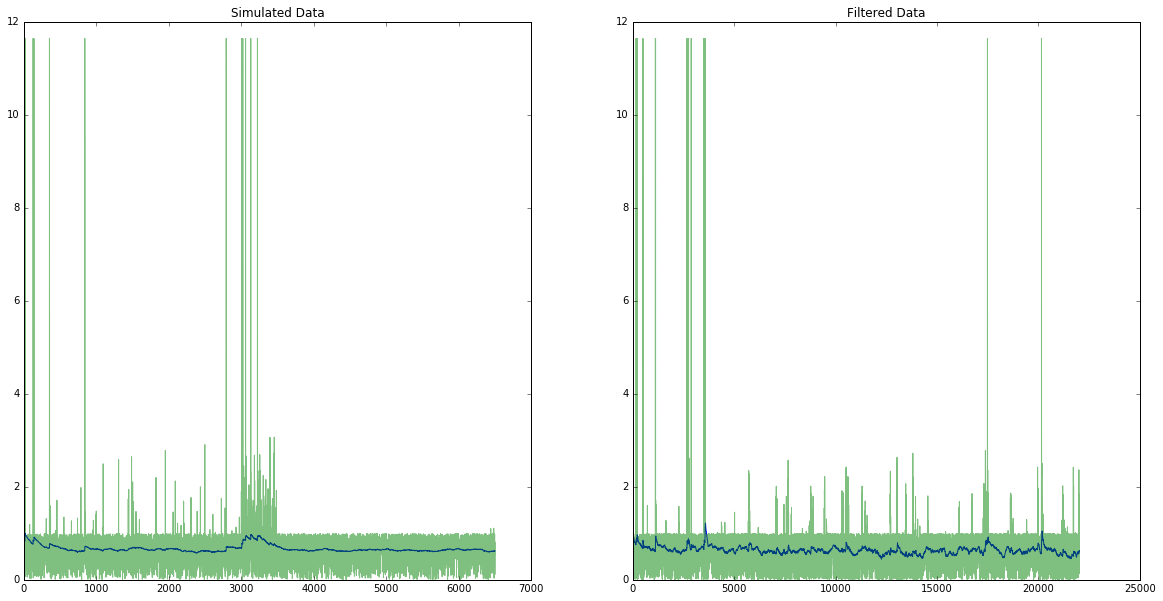

In [74]:
# Visualize change detection
# --------------------------

fig = plt.figure(figsize = (20,10))

a = 0.008

# determine length
L = diff1.shape[0]

# Simulated Data
ax1 = fig.add_subplot(121)
ax1.plot(smooth(diff1 , a))
ax1.plot(diff1 , alpha = 0.5)
ax1.set_title('Simulated Data')

# Processed data data
ax2 = fig.add_subplot(122)
ax2.plot(smooth(diff2 , a) )
ax2.plot(diff2 , alpha = 0.5)
ax2.set_title('Filtered Data')

plt.show()

In [75]:
# Function to generate a heatmap array based on Kalman filter
# -----------------------------------------------------------

def heatmap_fil(x , alpha):
    
    # signal length
    L = x.shape[0]
    
    # apply Kalman filter
    xk = smooth(x , alpha)
    
    # reshape arrays
    x1 = xk.reshape((1,L)) / np.max(xk)
    x2 = x.reshape((1,L)) / np.max(x)
    
    # Augment arrays
    big1 = np.concatenate((x1 , x1) , axis = 0)
    big2 = np.concatenate((x2 , x2) , axis = 0)
    
    # Join arrays
    big = np.concatenate((big1 , big2) , axis = 0)
    
    return big
        


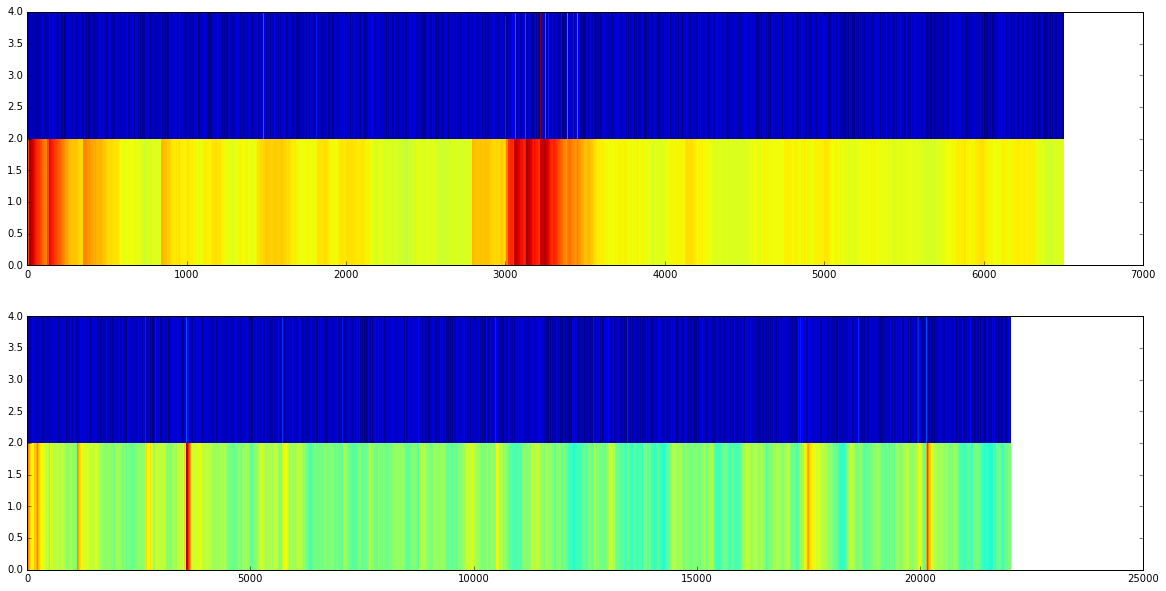

In [76]:
# visualize the heatmaps:
# -----------------------

fig = plt.figure(figsize = (20,10))

clr = plt.get_cmap('jet')

#
ht1 = heatmap_fil(diff1 , a)
ax1 = fig.add_subplot(2,1,1)
ax1.pcolor(ht1 , cmap = clr)

#
ht2 = heatmap_fil(diff2 , a)
ax2 = fig.add_subplot(2,1,2)
ax2.pcolor(ht2 , cmap = clr)

plt.show()

In [82]:
# Function to calculate Plugin Martingale:
# ---------------------------------------

def plugin_martingale(data , delay , sim = False):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
        
    if(sim):
        d = data
    
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.zeros(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i+1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.000000001
        
    # Extended sample
    p_value_neg = - p_value
    p_value_ref = 2.0 - p_value
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.
    
    # difference array
    diff_arr = np.zeros(power_mart.shape)

    # iterrate for plugin martingale calculation
    for i in range(1,L):
        
        # samples
        s1 = p_value_neg[:i]
        s2 = p_value[:i]
        s3 = p_value_ref[:i]
        
        # concatenation
        s12 = np.concatenate((s1 , s2) , axis = 0)
        sample = np.concatenate((s12 , s3) , axis  = 0)
        
        # Estimate pdf
        den = PDF(sample, bw_method='silverman')
        
        # Integral
        A = den.integrate_box_1d(0,1)
        
        # Evaluate
        f =  den.evaluate(p_value[i]) / A
        M += np.log(f)
        power_mart[i] = M
        diff_arr[i] = np.absolute(np.log(f))
    
    # First Element
    power_mart[0] = power_mart[1]
    
    
    return power_mart , diff_arr

In [ ]:
# Tune for delay:
#----------------

# integration resolution
resolution = 100

# selected delay array
delay_array = np.linspace(1,500,500)

# Dimensions
rows = len(delay_array)

# Initiation of measure array
measure_m = np.zeros((rows,))

for i in range(rows):
    
    # specify delsy
    de = int(delay_array[i])
    
    # display progress
    display.clear_output(wait=True)
    display.display('current step :  ' + str(i + 1) + ' out of ' + str(rows))
        
    # evaluate the difference
    pmar, dif = plugin_martingale(data, de)
        
    # maximum data Matthew
    dif_max = np.max(dif[17000:18000])
        
    # Put in measure array
    measure_m[i] = dif_max


                   

'current step :  8 out of 500'

---